### **0. Setup**

In [80]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# my_pal = ['grey', 'mediumseagreen']
my_pal = ['grey', 'mediumseagreen', 'dodgerblue', 'darkviolet']

# Make a folder if it not there yet and if needed
# !mkdir ../jupyter_figures

# set the directory where the data files are waiting
directory = '/Users/ShokenLEE/Desktop/DATA/2022 7-9/P-225 nLD and Sun2,1/Sun2'

### **1. Concanatate all the CSV files**

In [81]:
df = pd.DataFrame()

for path, subdirs, files in os.walk(directory):
    for file in files:
        if file.endswith('csv'):
            _df = pd.read_csv(os.path.join(path, file))
            df = pd.concat([df, _df], axis=0)

In [82]:
df.head()

,,Area,Mean,Circ.,AR,Round,Solidity,DAPI mean,Tag mean,File name
0,1,218.654,8222.540,0.964,1.339,0.747,1.004,4960.687,2500.287,9-29-22 U2OSctrl oleate 488BODIPY 561Sun2 t2-0...
1,2,335.517,6181.895,0.957,1.272,0.786,0.995,4739.200,2372.423,9-29-22 U2OSctrl oleate 488BODIPY 561Sun2 t2-0...
2,3,72.484,8196.588,0.640,2.500,0.400,0.989,4593.700,2473.031,9-29-22 U2OSctrl oleate 488BODIPY 561Sun2 t2-0...
3,4,242.369,7878.091,0.960,1.152,0.868,0.994,4864.654,2500.203,9-29-22 U2OSctrl oleate 488BODIPY 561Sun2 t2-0...
4,5,316.101,4497.822,0.974,1.232,0.812,1.000,5109.240,2447.643,9-29-22 U2OSctrl oleate 488BODIPY 561Sun2 t2-0...


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 16
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0              494 non-null    int64  
 1   Area       494 non-null    float64
 2   Mean       494 non-null    float64
 3   Circ.      494 non-null    float64
 4   AR         494 non-null    float64
 5   Round      494 non-null    float64
 6   Solidity   494 non-null    float64
 7   DAPI mean  494 non-null    float64
 8   Tag mean   494 non-null    float64
 9   File name  494 non-null    object 
dtypes: float64(8), int64(1), object(1)
memory usage: 42.5+ KB


#### Check the number of files

In [84]:
files = df['File name'].unique()
print(len(files))

26


### **2. Add columns**

####  **Cell_type**

In [85]:
df.loc[df['File name'].str.contains('Sctrl'), 'Cell type'] = 'Control'
df.loc[df['File name'].str.contains('KO'), 'Cell type'] = 'CTDNEP1 KO'

#### **siRNA type**

In [28]:
df.loc[df['File name'].str.contains('siCtrl'), 'siRNA type'] = 'siCtrl'
df.loc[df['File name'].str.contains('siSun2'), 'siRNA type'] = 'siSun2'
# df.loc[df['File name'].str.contains('siCDS1'), 'siRNA type'] = 'siCDS1'
# df.loc[df['File name'].str.contains('siCDS2'), 'siRNA type'] = 'siCDS2'
# df.loc[df['File name'].str.contains('siPIS'), 'siRNA type'] = 'siPIS'

#### **Plasmid type**

In [7]:
df.loc[df['File name'].str.contains('WT'), 'Plasmid type'] = 'WT'
df.loc[df['File name'].str.contains('DE'), 'Plasmid type'] = 'DE'

#### **Drug type**

In [86]:
df.loc[df['File name'].str.contains('BSA'), 'Drug type'] = 'BSA'
df.loc[df['File name'].str.contains('oleate'), 'Drug type'] = 'Oleate'

#### **Date**

In [14]:
df.loc[df['File name'].str.contains('9-13'), 'Date'] = '9-13'
df.loc[df['File name'].str.contains('9-29'), 'Date'] = '9-29'

#### **Image number**

In [87]:
df['Image number'] = df['File name'].str[-7:-4]

##### Check the number is correctly extracted

In [88]:
print(list(df['Image number'].unique())[1])

005


#### **Tag expression**

##### **Check Tag intensity**

(1000.0, 4000.0)

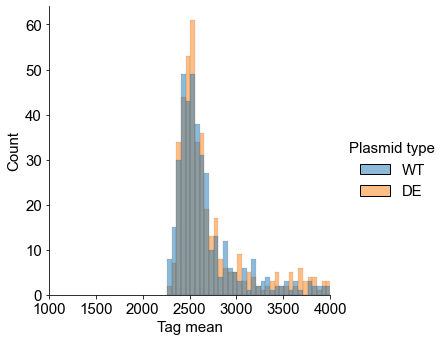

In [11]:
hist = sns.displot(data=df, x='Tag mean', hue='Plasmid type', hue_order=['WT', 'DE'], binwidth=50)
plt.xlim([1000,4000])

##### **Determine expression (+) or (-) by a threshold**

In [11]:
# Set the threshold
min_tag_intensity = 3200

# Sort Tag mean based on the threshold
df['Tag expression'] = df.apply(lambda x: '(+)' if x['Tag mean'] > min_tag_intensity else '(-)', axis=1)

#### **C3 channel intensity (background subtracted)**

##### **C3 distribution**

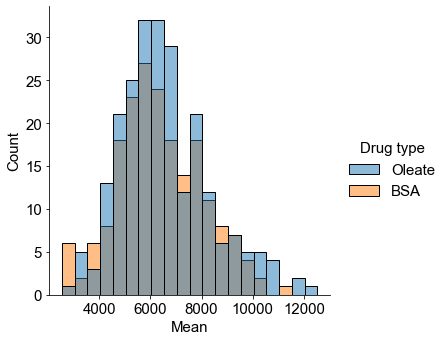

In [99]:
hist = sns.displot(x='Mean', data=df, hue='Drug type', binwidth=500)
# hist = sns.displot(x='Mean', data=df, col='Cell type', hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal, binwidth=500)

In [90]:
# df.groupby('Tag expression')['Mean'].min()
df.groupby(['Drug type'])['Mean'].mean()

Drug type
BSA       6332.726855
Oleate    6469.601835
Name: Mean, dtype: float64

##### **Background subtraction from C3 intensity value**

In [89]:
background_C3 = 2000

df['C3 mean - background'] = df['Mean'] - background_C3

##### **Background subtraction from C4 intensity value**

In [32]:
background_C2 = 700

df['C2 mean - background'] = df['Mean'] - background_C2

#### **Normalized C3 channel intensity (background subtracted)**

In [18]:
# set the baseline, which is either siCtrl for control cells or plasmid (-) cells
# C3_mean_baseline = np.mean(df[df['Tag expression']=='(-)']['C3 mean - background'])
# C3_mean_baseline = np.mean(df[(df['Cell type'] == 'Control') & (df['siRNA type'] == 'siCtrl')]['C3 mean - background'])
C3_mean_baseline = np.mean(df[(df['Cell type'] == 'Control') & (df['Drug type'] == 'DMSO')]['C3 mean - background'])

# then normalize
df['C3-Back_normalized'] = df['C3 mean - background'] / C3_mean_baseline

#### **ROI number**

In [91]:
df = df.rename(columns={' ': 'ROI number'})

#### **Sample type (for Tukey test)**

In [18]:
# specify what columns are joined to name 'Sample_type'

# sampletype_columns = ['Cell type', 'Plasmid type', 'Tag expression']
sampletype_columns = ['Cell type', 'siRNA type']

df['Sample_type'] = df[sampletype_columns].agg('_'.join, axis=1)

### **3. Exclude mitotic cells and nuclei with small area**

#### **3-1. Mitotic cells**

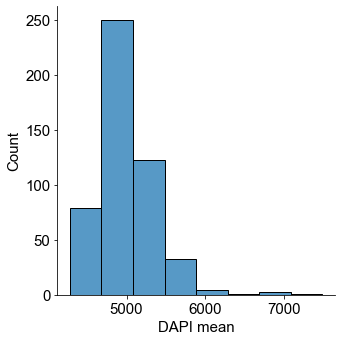

In [92]:
# hist = sns.displot(data=df, x='DAPI mean', hue='Cell type', hue_order=['Control', 'CTDNEP1 KO'], binwidth=400)
hist = sns.displot(data=df, x='DAPI mean', binwidth=400)
# plt.xlim([1000,4000])

#### **Remove cells with too hight DAPI intensity, which are likely mitotic cells**

In [93]:
max_DNA_intensity = 7000

df = df[df['DAPI mean'] < max_DNA_intensity]

#### **3-2. Nuclei with small area**

In [94]:
min_area_of_roi = 60
# max_area_of_roi = 200
df = df[(df['Area'] > min_area_of_roi)]

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433 entries, 0 to 16
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ROI number            433 non-null    int64  
 1   Area                  433 non-null    float64
 2   Mean                  433 non-null    float64
 3   Circ.                 433 non-null    float64
 4   AR                    433 non-null    float64
 5   Round                 433 non-null    float64
 6   Solidity              433 non-null    float64
 7   DAPI mean             433 non-null    float64
 8   Tag mean              433 non-null    float64
 9   File name             433 non-null    object 
 10  Cell type             433 non-null    object 
 11  Drug type             433 non-null    object 
 12  Image number          433 non-null    object 
 13  C3 mean - background  433 non-null    float64
dtypes: float64(9), int64(1), object(4)
memory usage: 50.7+ KB


### **4. Inspect the data**

#### **4-1. Check cell counts per sample**

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Number of cells')

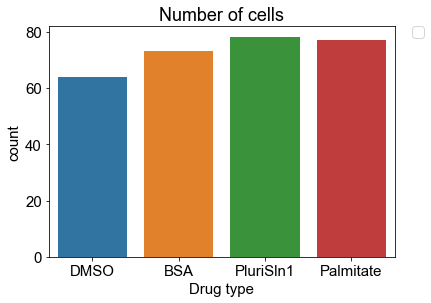

In [17]:
fig = plt.figure()
ax_count = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# ax_count = sns.countplot(data=df, x='Sample_type')
ax_count = sns.countplot(data=df, x='Drug type')
# ax_count = sns.countplot(data=df, x='Plasmid type', order=['WT', 'DE'], hue='Tag expression', hue_order=['(-)', '(+)'], palette=my_pal)
# ax_count = sns.countplot(data=df, x='Cell type', order=['Control', 'CTDNEP1 KO'], 
#                          hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Number of cells')
# ax_count.set_xticklabels(labels=samples_order, rotation=45, ha='right')

In [96]:
# df.groupby(['Plasmid type', 'Tag expression']).size()
# df.groupby(['Cell type', 'siRNA type']).size()
df.groupby(['Drug type']).size()

Drug type
BSA       197
Oleate    236
dtype: int64

#### **4-3. C3 channel normalized intensity**

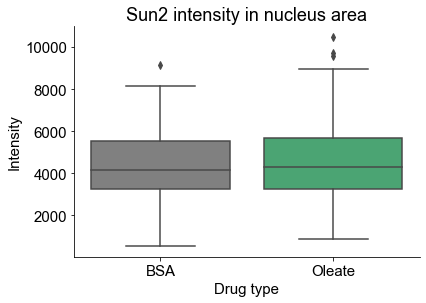

In [97]:
fig = plt.figure(figsize=(6,4))
ax_box = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# For rescue experiments:
# ax_box = sns.boxplot(data=df, x='Plasmid type', y='C3-Back_normalized', order=['WT', 'DE'], hue='Tag expression', hue_order=['(-)', '(+)'], palette=my_pal)
# plt.legend(title='Flag expression', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# # For siRNA experiments:
# ax_box = sns.boxplot(data=df, x='Cell type', y='C3-Back_normalized', order=['Control', 'CTDNEP1 KO'], 
#                      hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal)
# plt.legend(title='siRNA', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# For Drug experiments:
ax_box = sns.boxplot(data=df, x='Drug type', y='C3 mean - background',
                     order=['BSA', 'Oleate'], palette=my_pal)
# plt.legend(title='Drug', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# Used in common:
plt.title('Sun2 intensity in nucleus area')
plt.ylabel('Intensity')
ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)

In [98]:
fig.savefig(directory + '/Sun2_intensity.pdf', bbox_inches='tight', transparent=True)

#### **Scatter plot (Tag vs C3)**

Text(24.700000000000003, 0.5, 'Number of nuclear LDs')

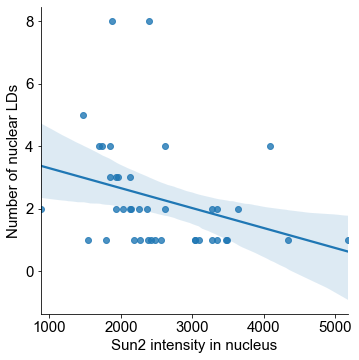

In [25]:
scatter = sns.lmplot(x='C4 mean - background', y='nLD', data=df[df['nLD'] > 0], legend_out=False)
plt.xlabel('Sun2 intensity in nucleus')
plt.ylabel('Number of nuclear LDs')

In [26]:
scatter.savefig(directory + '/Tag_vs_C3.jpg', bbox_inches='tight')

In [13]:
df[df['C3 mean - background'] > 10000]

,,Area,Mean,Circ.,AR,Round,Solidity,DAPI mean,Tag mean,File name,Image number,C3 mean - background,C4 mean - background
40,41,1.895,4479.122,0.894,1.266,0.790,0.988,31844.805,12630.317,6-10-21 U2OSWT Oleate800uM 488BODIPY 561Sun2 t...,005,10330.317,2479.122
59,60,1.433,4067.581,0.874,1.058,0.945,1.000,31593.935,13931.903,6-10-21 U2OSWT Oleate800uM 488BODIPY 561Sun2 t...,005,11631.903,2067.581
87,88,3.976,3106.605,0.881,1.089,0.918,0.940,28978.186,13709.314,6-10-21 U2OSWT Oleate800uM 488BODIPY 561Sun2 t...,005,11409.314,1106.605


#### **4-4. Tukey test**

In [33]:
res = pairwise_tukeyhsd(df['C3-Back_normalized'], df['Sample_type'], alpha=0.05)

In [34]:
print(res)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
CTDNEP1 KO_siCDS1 CTDNEP1 KO_siCDS2  -0.0678    0.9 -0.2676   0.132  False
CTDNEP1 KO_siCDS1 CTDNEP1 KO_siCtrl  -0.0465    0.9 -0.2442  0.1513  False
CTDNEP1 KO_siCDS1  CTDNEP1 KO_siPIS   0.0839    0.9 -0.1134  0.2811  False
CTDNEP1 KO_siCDS1    Control_siCDS1   1.2579  0.001  1.0666  1.4492   True
CTDNEP1 KO_siCDS1    Control_siCDS2   0.8275  0.001  0.6403  1.0147   True
CTDNEP1 KO_siCDS1    Control_siCtrl   0.3647  0.001  0.1806  0.5489   True
CTDNEP1 KO_siCDS1     Control_siPIS   0.5323  0.001  0.3457   0.719   True
CTDNEP1 KO_siCDS2 CTDNEP1 KO_siCtrl   0.0213    0.9 -0.1642  0.2068  False
CTDNEP1 KO_siCDS2  CTDNEP1 KO_siPIS   0.1517 0.2002 -0.0333  0.3367  False
CTDNEP1 KO_siCDS2    Control_siCDS1   1.3257  0.001  1.1471  1.5043   True
CTDNEP1 KO_siCDS2    Cont